## mmWave ECG Alignment Benchmark

Found 3 files:
  - replay_1.json
  - replay_2.json
  - replay_3.json


統計資訊
總資料點數: 270
最大振幅: 1.0121
最小振幅: -1.1056
平均振幅: 0.0043
標準差: 0.3822

檔案詳情:
------------------------------------------------------------

檔案: replay_1.json
  資料點: 90
  Frame數: 6
  索引範圍: [0, 90)
  平均心率: 63.89 bpm
  心率範圍: 50.22 - 75.33 bpm

檔案: replay_2.json
  資料點: 90
  Frame數: 6
  索引範圍: [90, 180)
  平均心率: 61.10 bpm
  心率範圍: 50.22 - 71.99 bpm

檔案: replay_3.json
  資料點: 90
  Frame數: 6
  索引範圍: [180, 270)
  平均心率: 61.94 bpm
  心率範圍: 56.92 - 66.96 bpm


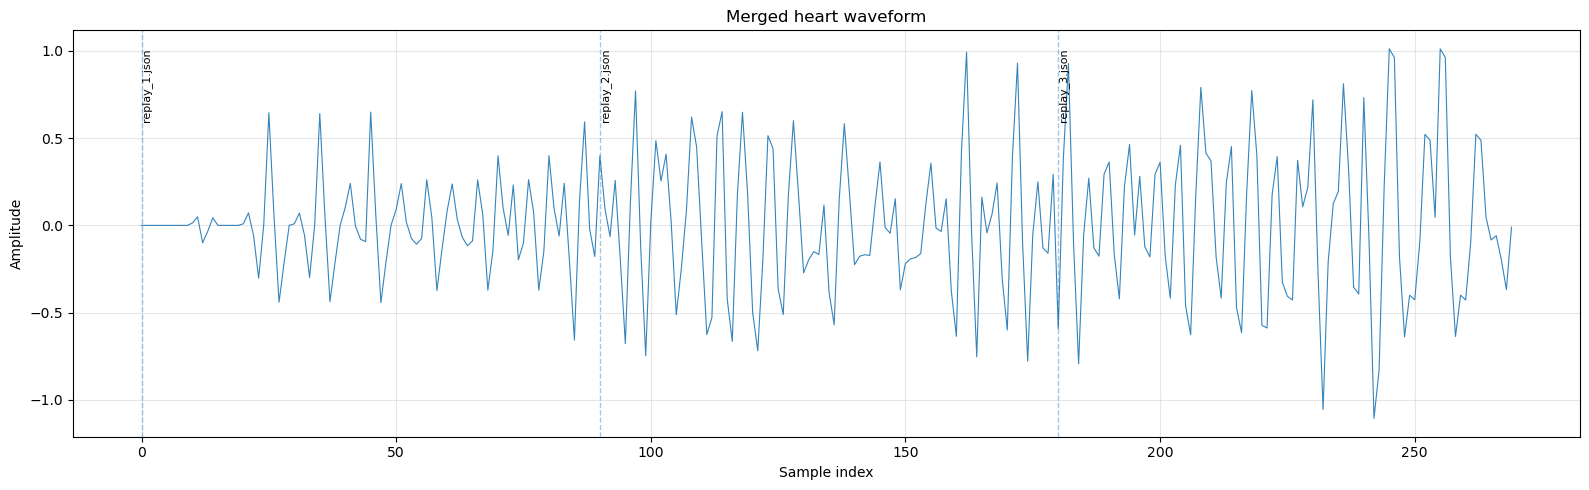

In [7]:
#!/usr/bin/env python3
# -*- coding: utf-8 -*-
"""
Unified mmWave vitals merger using load_frames(paths).
- Keeps the file-reading style from the second snippet (load_frames).
- Extracts per-frame vitals.heartWaveform and merges across files.
- Produces stats and a plot.

Usage:
    python mmwave_heart_merge.py /path/to/folder [-o outputs]

In notebooks:
    from mmwave_heart_merge import process_vitals_folder
    summary = process_vitals_folder("data", outdir="outputs")
"""
import os
import re
import glob
import json
import argparse
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from IPython.display import display, HTML

# -----------------------------
# I/O helpers
# -----------------------------

def natural_sort_key(filename):
    """自然排序：replay_1, replay_2, ..., replay_10"""
    numbers = re.findall(r'\d+', filename)
    return int(numbers[0]) if numbers else 0

def find_replay_jsons(folder):
    """Find replay_*.json under folder, natural-sorted."""
    pattern = os.path.join(folder, "replay_*.json")
    files = glob.glob(pattern)
    files.sort(key=lambda x: natural_sort_key(os.path.basename(x)))
    return files

# -----------------------------
# Core loader following the "load_frames(paths)" pattern
# -----------------------------

def load_frames(paths):
    """
    Load and parse JSON frame data from multiple files.
    Returns a pandas DataFrame sorted by timestamp.
    Columns:
        source, frame, timestamp_ms,
        heartWaveform, heartRate, breathRate, rangeBin, breathDeviation,
        numTracks, numPoints
    """
    rows = []
    for p in paths:
        if not os.path.exists(p):
            print(f"[warn] file not found: {p}")
            continue
        with open(p, "r", encoding="utf-8") as f:
            root = json.load(f)

        for entry in root.get("data", []):
            fd = entry.get("frameData", {}) or {}
            ts = entry.get("timestamp", None)  # ms
            frame_num = fd.get("frameNum", None)

            vit = fd.get("vitals", None) or {}
            hw = vit.get("heartWaveform", None)
            hr = vit.get("heartRate", None)
            br = vit.get("breathRate", None)
            rb = vit.get("rangeBin", None)
            bd = vit.get("breathDeviation", None)

            rows.append({
                "source": os.path.basename(p),
                "frame": frame_num,
                "timestamp_ms": ts,
                "numTracks": fd.get("numDetectedTracks", None),
                "numPoints": fd.get("numDetectedPoints", None),
                "heartWaveform": hw if isinstance(hw, list) else None,
                "heartRate": hr,
                "breathRate": br,
                "rangeBin": rb,
                "breathDeviation": bd,
            })

    df = pd.DataFrame(rows).dropna(subset=["timestamp_ms"])
    df = df.sort_values(["timestamp_ms", "source", "frame"], kind="mergesort").reset_index(drop=True)
    return df

# -----------------------------
# Processing and plotting
# -----------------------------

def merge_heart_waveforms(df):
    """
    Merge all available heartWaveform arrays in time order.
    Returns:
        wave (np.ndarray), segments (list of dict per source file)
    """
    all_wave = []
    segments = []  # per-file segment boundaries for plotting and stats

    # record cumulative offset when each file starts
    cur_offset = 0
    for src, sub in df.groupby("source", sort=False):
        file_points = 0
        frames_info = []
        for _, row in sub.iterrows():
            wf = row.get("heartWaveform", None)
            if isinstance(wf, list) and len(wf) > 0:
                start = cur_offset + file_points
                all_wave.extend(wf)
                end = cur_offset + file_points + len(wf)
                frames_info.append({
                    "frameNum": int(row["frame"]) if pd.notna(row["frame"]) else None,
                    "timestamp": float(row["timestamp_ms"]),
                    "heartRate": float(row["heartRate"]) if pd.notna(row["heartRate"]) else None,
                    "waveformLength": int(len(wf)),
                    "startIndex": int(start),
                    "endIndex": int(end)
                })
                file_points += len(wf)

        segments.append({
            "filename": src,
            "totalPoints": int(file_points),
            "frameCount": int(len(frames_info)),
            "startIndex": int(cur_offset),
            "endIndex": int(cur_offset + file_points),
            "frame_info": frames_info
        })
        cur_offset += file_points

    return np.asarray(all_wave, dtype=float), segments

def print_statistics(wave, segments, df_meta=None):
    """Print summary statistics and per-file info."""
    if wave.size == 0:
        print("[warn] No heartWaveform data found.")
        return

    print("\n" + "="*60)
    print("統計資訊")
    print("="*60)
    print(f"總資料點數: {len(wave)}")
    print(f"最大振幅: {np.max(wave):.4f}")
    print(f"最小振幅: {np.min(wave):.4f}")
    print(f"平均振幅: {np.mean(wave):.4f}")
    print(f"標準差: {np.std(wave):.4f}\n")

    print("檔案詳情:")
    print("-"*60)
    for seg in segments:
        print(f"\n檔案: {seg['filename']}")
        print(f"  資料點: {seg['totalPoints']}")
        print(f"  Frame數: {seg['frameCount']}")
        print(f"  索引範圍: [{seg['startIndex']}, {seg['endIndex']})")

        hrs = [fi["heartRate"] for fi in seg["frame_info"] if fi["heartRate"] is not None and fi["heartRate"] > 0]
        if hrs:
            print(f"  平均心率: {np.mean(hrs):.2f} bpm")
            print(f"  心率範圍: {np.min(hrs):.2f} - {np.max(hrs):.2f} bpm")

def plot_heart_waveform(wave, segments, save_path=None):
    """
    Plot the merged heart waveform and per-file counts.
    Conforms to the one-chart-per-figure guidance when called separately.
    """
    if wave.size == 0:
        return

    # Primary waveform
    plt.figure(figsize=(16, 5))
    t = np.arange(len(wave))

    plt.plot(t, wave, linewidth=0.8, alpha=0.9)
    plt.xlabel("Sample index")
    plt.ylabel("Amplitude")
    plt.title("Merged heart waveform")
    plt.grid(True, alpha=0.3)

    # Mark file boundaries
    ymax = np.max(wave) if wave.size else 1.0
    for seg in segments:
        x = seg["startIndex"]
        plt.axvline(x=x, linestyle="--", alpha=0.4, linewidth=1.0)
        plt.text(x, ymax, seg["filename"], rotation=90, va="top", fontsize=8)

    plt.tight_layout()
    if save_path:
        plt.savefig(save_path, dpi=200, bbox_inches="tight")
    plt.show()

# -----------------------------
# High-level API
# -----------------------------

def process_vitals_folder(folder_path, outdir="outputs", fs_hint=10.0):
    """
    Find and load replay_*.json, merge vitals.heartWaveform, print stats, and plot.
    Returns:
        {
            "waveforms": np.ndarray,
            "segments": list[dict],
            "csv": path,
            "plot": path
        }
    """
    files = find_replay_jsons(folder_path)
    if not files:
        print(f"[error] No replay_*.json files found in: {folder_path}")
        return None

    print(f"Found {len(files)} files:")
    for f in files:
        print("  -", os.path.basename(f))
    print()

    df = load_frames(files)
    if df.empty:
        print("[error] No frames with timestamps found.")
        return None

    wave, segments = merge_heart_waveforms(df)
    if wave.size == 0:
        print("[error] No heartWaveform data found in frames.")
        return None

    # Outputs
    os.makedirs(outdir, exist_ok=True)

    # time axis assuming approx constant sampling fs_hint
    fs = float(fs_hint)
    t_uni = np.arange(len(wave), dtype=float) / fs if len(wave) > 0 else np.array([], dtype=float)

    # CSV with t_sec and heartbeat
    csv_path = os.path.join(outdir, "heart_rate_series.csv")
    result_df = pd.DataFrame({
        "t_sec": t_uni,
        "heartbeat": wave.astype(float)
    })
    result_df.to_csv(csv_path, index=False)

    # Plot and save as heartbeat.png
    heart_png = os.path.join(outdir, "heartbeat.png")
    print_statistics(wave, segments, df_meta=df)
    plot_heart_waveform(wave, segments, save_path=heart_png)

    # Summary with the exact required structure
    summary = {
        "samples": int(len(t_uni)),
        "duration_s": float(t_uni[-1] - t_uni[0]) if len(t_uni) > 1 else 0.0,
        "fs_Hz": float(fs),
        "est_hr_bpm": None,
        "csv": csv_path,
        "heartbeat_png": heart_png,
        "dataframe": result_df,
    }
    return summary

# -----------------------------
# CLI
# -----------------------------

def main():
    ap = argparse.ArgumentParser()
    ap.add_argument("folder", help="Folder containing replay_*.json")
    ap.add_argument("-o", "--outdir", default="outputs", help="Output directory")
    args = ap.parse_args()

    summary = process_vitals_folder(args.folder, outdir=args.outdir)
    if summary is None:
        raise SystemExit(1)


def transform_to_dataframe(summary):
    y= summary['dataframe']['heartbeat'].values
    dt=0.1
    t=np.arange(len(y))*dt
    df=pd.DataFrame({'t_sec':t,'mmv':y})
    return df

if __name__ == "__main__":
    summary = process_vitals_folder(r"E:\重要文件\毫米波\radar-heartbeat-detection\實驗區\data\sample_0", outdir="outputs")
    df_mmv= transform_to_dataframe(summary)

    


In [15]:
import os
import numpy as np
import pandas as pd
from typing import Tuple

ECG_CSV_PATH = r'E:\重要文件\毫米波\radar-heartbeat-detection\實驗區\data\sample_0\1_1lead.csv'  # 改路徑請修改此行
FS_FALLBACK = 250.0                     # 若無時間欄，使用此取樣率

def load_ecg_csv(path: str) -> Tuple[pd.DataFrame, float, str]:
    """
    回傳: (df 只含 ['t_sec','ecg'], fs_Hz, info)
    規則:
      - 若有 time/t/timestamp/sec/ms 等欄，嘗試判斷單位並換算成秒
      - 若沒有時間欄，用 FS_FALLBACK 與樣本索引建立時間
    """
    if not os.path.exists(path):
        raise FileNotFoundError(f'File not found: {path}')
    df0 = pd.read_csv(path)
    if df0.empty:
        raise ValueError('Empty CSV.')

    cols = [c.lower().strip() for c in df0.columns]
    df0.columns = cols
    info = []

    # 嘗試找到時間欄
    t_col = next((c for c in ['t','time','timestamp','time_s','sec','seconds','ms','millisecond','milliseconds']
                  if c in df0.columns), None)

    if t_col is not None:
        t = pd.to_numeric(df0[t_col], errors='coerce').astype(float).values
        if len(t) < 2:
            raise ValueError('Time column too short to infer fs.')
        dt = np.diff(t)
        dt_med = float(np.nanmedian(dt))

        # 判斷秒或毫秒或索引
        if dt_med > 2:
            # 可能是樣本索引
            if (t % 1 == 0).mean() > 0.95:
                info.append('time looks like sample indices; using FS_FALLBACK')
                fs = float(FS_FALLBACK)
                t_sec = np.arange(len(t)) / fs
            else:
                info.append('time treated as seconds')
                t_sec = t
                fs = float(1.0 / np.nanmedian(np.diff(t_sec)))
        elif dt_med > 0.02:
            info.append('time treated as seconds')
            t_sec = t
            fs = float(1.0 / np.nanmedian(np.diff(t_sec)))
        else:
            # 可能是毫秒
            if dt_med < 0.002:
                info.append('time treated as seconds')
                t_sec = t
                fs = float(1.0 / np.nanmedian(np.diff(t_sec)))
            else:
                info.append('time treated as milliseconds; converted to seconds')
                t_sec = t 
                fs = float(1.0 / np.nanmedian(np.diff(t_sec)))

        # 選 ECG 欄
        ecg_col = next((c for c in ['ecg','ecg_mv','lead1','lead_i','v1','value','signal']
                        if c in df0.columns and c != t_col), None)
        if ecg_col is None:
            # 取第一個非時間欄
            rest = [c for c in df0.columns if c != t_col]
            if not rest:
                raise ValueError('No ECG column found.')
            ecg_col = rest[0]
        ecg = pd.to_numeric(df0[ecg_col], errors='coerce').astype(float).values
    else:
        info.append('no time column; using FS_FALLBACK and sample index')
        fs = float(FS_FALLBACK)
        first_col = df0.columns[0]
        ecg = pd.to_numeric(df0[first_col], errors='coerce').astype(float).values
        t_sec = np.arange(len(ecg)) / fs

    df = pd.DataFrame({'t_sec': t_sec, 'ecg': ecg})
    return df, fs, '; '.join(info) if info else 'inferred automatically'
df_ecg, fs_Hz, info = load_ecg_csv(ECG_CSV_PATH)

def normalize_ts(df: pd.DataFrame,
                 y_candidates=('ecg','mmv','mmwave','heartbeat','value','signal'),
                 dt: float|None=None,
                 amp_method: str='absmax',  # 'absmax' or 'minmax'
                 eps: float=1e-12) -> pd.DataFrame:
    # 找 y 欄
    cols_lower = {c.lower(): c for c in df.columns}
    ycol = next((cols_lower[c] for c in cols_lower if c in y_candidates), None)
    if ycol is None:
        raise KeyError(f"找不到訊號欄。可用候選：{y_candidates}；現有欄位：{list(df.columns)}")

    out = df.copy()

    # 確保 t_sec
    if 't_sec' not in out.columns:
        if dt is None:
            raise KeyError("缺少 't_sec' 且未提供 dt。請給 dt，例如 0.1")
        out.insert(0, 't_sec', np.arange(len(out))*dt)

    # 只保留 t_sec + y 並統一命名
    out = out[['t_sec', ycol]].rename(columns={ycol: 'ecg'}).copy()

    # 幅度歸一到 [-1, 1]
    x = out['ecg'].astype(float).to_numpy()
    if amp_method == 'absmax':
        # 保零點，適合雙極性（ECG）
        s = np.nanmax(np.abs(x))
        s = s if s > eps else 1.0
        x_norm = x / s
    elif amp_method == 'minmax':
        # 線性映射到 [-1, 1]
        x_min, x_max = np.nanmin(x), np.nanmax(x)
        if x_max - x_min < eps:
            x_norm = np.zeros_like(x)
        else:
            x_norm = 2.0 * (x - x_min) / (x_max - x_min) - 1.0
    else:
        raise ValueError("amp_method must be 'absmax' or 'minmax'.")

    out['ecg'] = np.clip(x_norm, -1.0, 1.0)
    return out
def pltot_fixed(df, title='Signal', label='sig'):
    import matplotlib.pyplot as plt
    plt.figure(figsize=(12,4))
    plt.plot(df['t_sec'], df['ecg'], label=label)
    plt.xlabel('Time (s)'); plt.ylabel('Amplitude'); plt.title(title)
    plt.grid(); plt.legend(); plt.tight_layout(); plt.show()

def combine_plots(df1, df2, title='Combined Signals', label1='sig1', label2='sig2'):
    import matplotlib.pyplot as plt
    plt.figure(figsize=(12,4))
    plt.plot(df1['t_sec'], df1['ecg'], label=label1)
    plt.plot(df2['t_sec'], df2['ecg'], label=label2)
    plt.xlabel('Time (s)'); plt.ylabel('Amplitude'); plt.title(title)
    plt.grid(); plt.legend(); plt.tight_layout(); plt.show()

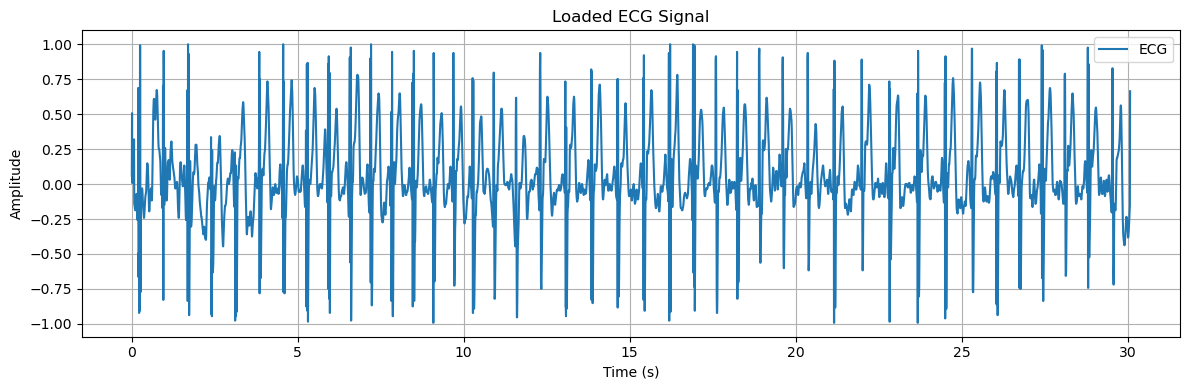

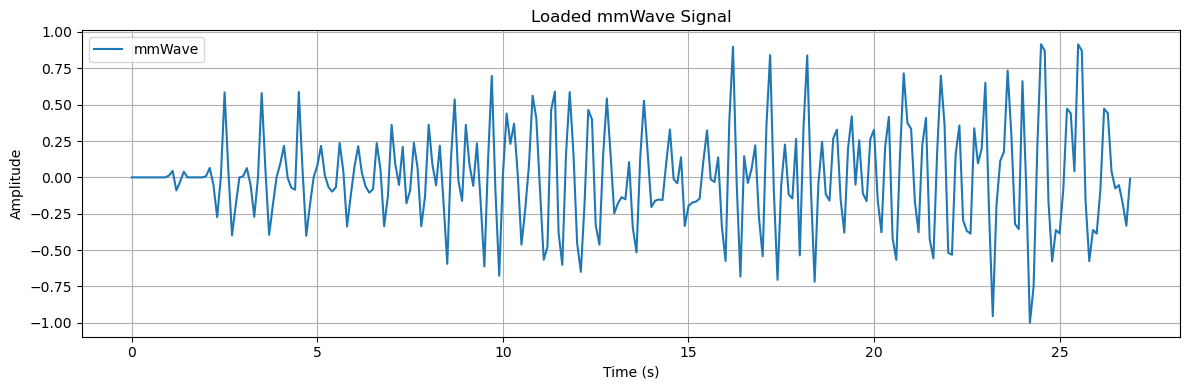

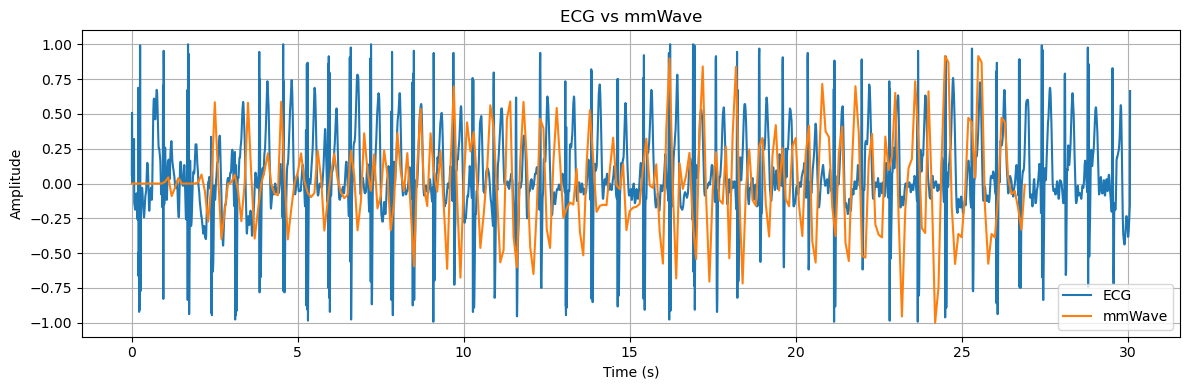

In [16]:

df_ecg_fixed = normalize_ts(df_ecg, y_candidates=('ecg',), dt=None)
pltot_fixed(df_ecg_fixed, title='Loaded ECG Signal', label='ECG')
df_mmv_fixed = normalize_ts(df_mmv, y_candidates=('mmv','mmwave','heartbeat','value','signal'), dt=0.1)
pltot_fixed(df_mmv_fixed, title='Loaded mmWave Signal', label='mmWave')
combine_plots(df_ecg_fixed, df_mmv_fixed, title='ECG vs mmWave', label1='ECG', label2='mmWave')

c:\Users\op237\miniconda3\envs\mmv-env\Lib\site-packages\scipy\signal\_signaltools.py:247: RuntimeWarning: Use of fft convolution on input with NAN or inf results in NAN or inf output. Consider using method='direct' instead.
  return convolve(in1, _reverse_and_conj(in2), mode, method)


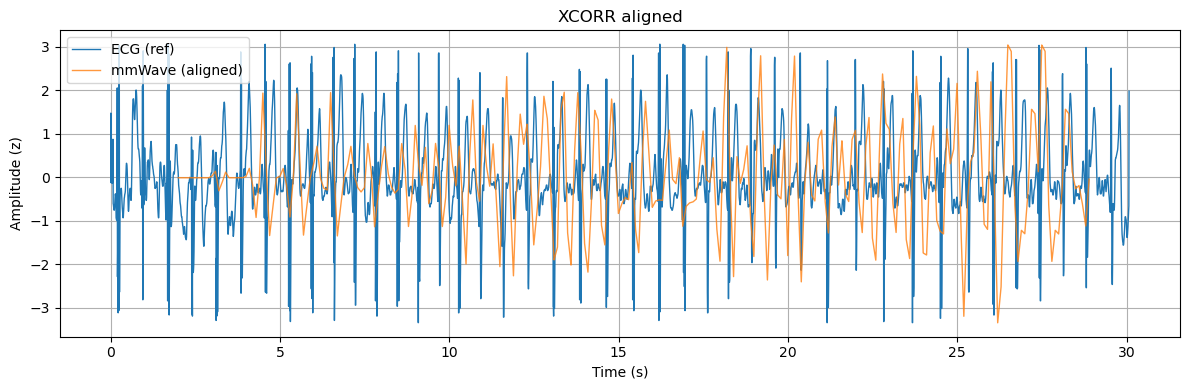

C:\Users\op237\AppData\Local\Temp\ipykernel_113236\667578378.py:164: RuntimeWarning: All-NaN slice encountered
  coh_pk = float(np.nanmax(Cxy[m])) if m.any() else np.nan
C:\Users\op237\AppData\Local\Temp\ipykernel_113236\667578378.py:39: RuntimeWarning: invalid value encountered in divide
  R /= np.abs(R) + 1e-12


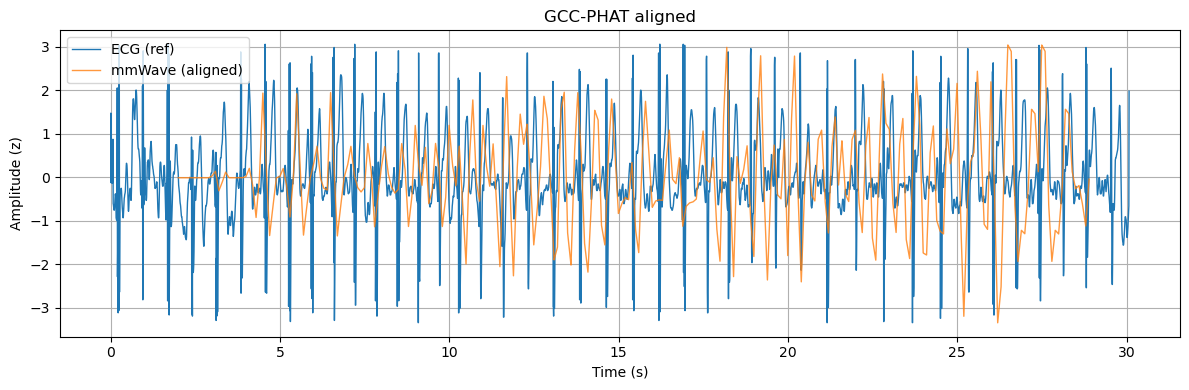

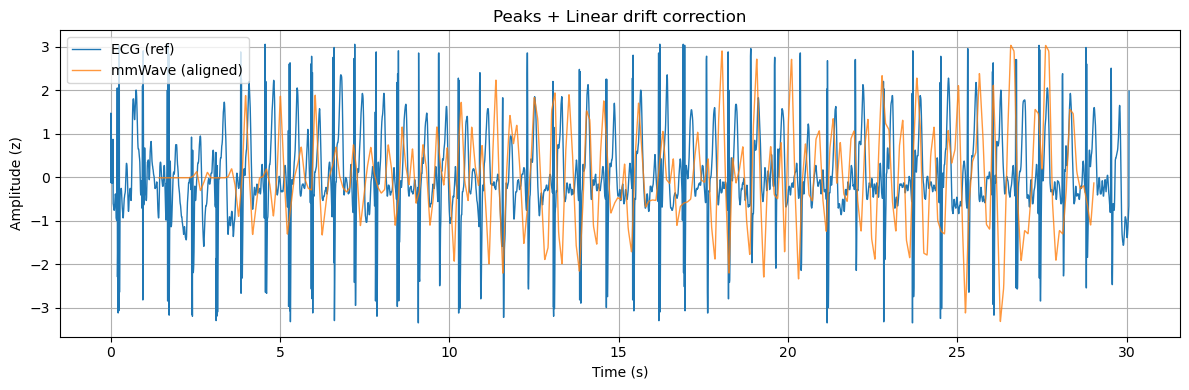

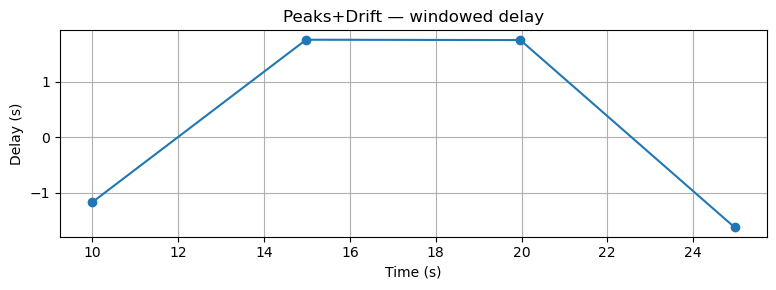

             pearson_r   z_mae  hr_ref_mean_bpm  hr_al_mean_bpm  ibi_rmse_s  \
method                                                                        
XCORR           0.0052  1.0949         129.9823        135.3869      0.2650   
GCC-PHAT        0.0052  1.0949         129.9823        135.3869      0.2650   
Peaks+Drift     0.0161  1.0880         129.9823        131.6976      0.2651   

             coherence_pk_0p8_3Hz  
method                             
XCORR                         NaN  
GCC-PHAT                      NaN  
Peaks+Drift                   NaN  


In [17]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy import signal, interpolate
from typing import Dict, Tuple, Callable

# ---------- 基礎工具 ----------
def to_common_grid(df_ref: pd.DataFrame, df_mov: pd.DataFrame) -> Tuple[np.ndarray,np.ndarray,np.ndarray]:
    """把 moving 訊號重採樣到 reference 的時間網格。要求兩者都有 t_sec, ecg。"""
    t_ref = df_ref['t_sec'].to_numpy(dtype=float)
    x_ref = df_ref['ecg'].to_numpy(dtype=float)
    t_mov = df_mov['t_sec'].to_numpy(dtype=float)
    x_mov = df_mov['ecg'].to_numpy(dtype=float)
    # 單調與去NaN
    m = np.isfinite(t_mov) & np.isfinite(x_mov)
    t_mov2, x_mov2 = t_mov[m], x_mov[m]
    if len(t_mov2) < 2:
        raise ValueError("moving signal is too short after NaN removal")
    f = interpolate.interp1d(t_mov2, x_mov2, kind='linear', bounds_error=False, fill_value=np.nan)
    x_mov_rs = f(t_ref)
    return t_ref, x_ref, x_mov_rs

def zscore(x):
    m, s = np.nanmean(x), np.nanstd(x) + 1e-12
    return (x - m)/s

def bounded_xcorr(x, y, fs, maxlag_s=2.0):
    c = signal.correlate(x, y, mode='full')
    l = signal.correlation_lags(len(x), len(y), mode='full')/fs
    m = np.abs(l) <= maxlag_s
    return l[m], c[m]

def gcc_phat_delay(x, y, fs, maxlag_s=2.0):
    # zero-pad to next pow2
    n = int(2**np.ceil(np.log2(len(x)+len(y))))
    X = np.fft.rfft(x, n)
    Y = np.fft.rfft(y, n)
    R = X * np.conj(Y)
    R /= np.abs(R) + 1e-12
    cc = np.fft.irfft(R, n)
    # circular shift to have lags symmetric
    cc = np.concatenate([cc[-(n//2):], cc[:(n//2)]])
    lags = np.arange(-n//2, n//2)/fs
    m = np.abs(lags) <= maxlag_s
    lags_m, cc_m = lags[m], cc[m]
    return lags_m[np.argmax(cc_m)]

def apply_shift(t, x, shift_s):
    """時間平移：輸出在原 t 上的插值值 x(t - shift)。"""
    return np.interp(t, t - shift_s, x, left=np.nan, right=np.nan)

def windowed_delay(t, x_mov, x_ref, fs, win_s=10.0, step_s=5.0, maxlag_s=2.0) -> Tuple[np.ndarray,np.ndarray]:
    win = int(win_s*fs); step = int(step_s*fs)
    centers, taus = [], []
    for s in range(0, len(t)-win, step):
        seg_m = x_mov[s:s+win]; seg_r = x_ref[s:s+win]
        l, c = bounded_xcorr(seg_m, seg_r, fs, maxlag_s=maxlag_s)
        if len(c) == 0 or not np.isfinite(c).any():
            continue
        taus.append(l[np.nanargmax(c)])
        centers.append(t[s+win//2])
    return np.asarray(centers), np.asarray(taus)

def lin_drift_correct(t, x, centers, taus):
    """tau(t)≈a t + b，先校正斜率a(等效取樣率差)，再校正平移b。"""
    if len(taus) < 2:
        return x
    A = np.vstack([centers, np.ones_like(centers)]).T
    a, b = np.linalg.lstsq(A, taus, rcond=None)[0]
    t_corr = t - (a*t + b)
    return np.interp(t, t_corr, x, left=np.nan, right=np.nan)

# ---------- 峰偵測與 HR/IBI ----------
def detect_peaks_simple(x, fs, z_thresh=0.5, min_dist_s=0.25):
    xz = zscore(x)
    distance = max(1, int(min_dist_s*fs))
    pk, prop = signal.find_peaks(xz, height=z_thresh, distance=distance)
    return pk

def match_peaks(t, idx_a, idx_b, max_gap_s=0.2) -> np.ndarray:
    """最近鄰配對，回傳配對索引 [ [ia, ib], ... ]"""
    ta, tb = t[idx_a], t[idx_b]
    out = []
    j = 0
    for i in range(len(ta)):
        while j+1 < len(tb) and abs(tb[j+1]-ta[i]) < abs(tb[j]-ta[i]):
            j += 1
        if abs(tb[j]-ta[i]) <= max_gap_s:
            out.append([i, j])
    return np.asarray(out, dtype=int)

def hr_metrics_from_peaks(t, idx):
    if len(idx) < 2:
        return np.nan, np.nan
    ibi = np.diff(t[idx])
    hr = 60.0/ibi
    return float(np.nanmean(hr)), float(np.nanstd(hr))

# ---------- 三種對齊方法 ----------
def align_xcorr(t, x_ref, x_mov, fs, maxlag_s=2.0):
    l, c = bounded_xcorr(x_mov, x_ref, fs, maxlag_s=maxlag_s)
    tau = l[np.argmax(c)]
    x_mov_al = apply_shift(t, x_mov, tau)
    return x_mov_al, {'tau_s': float(tau)}

def align_gccphat(t, x_ref, x_mov, fs, maxlag_s=2.0):
    tau = gcc_phat_delay(x_mov, x_ref, fs, maxlag_s=maxlag_s)
    x_mov_al = apply_shift(t, x_mov, tau)
    return x_mov_al, {'tau_s': float(tau)}

def align_peaks_drift(t, x_ref, x_mov, fs, maxlag_s=2.0):
    # 粗對齊
    l, c = bounded_xcorr(x_mov, x_ref, fs, maxlag_s=maxlag_s)
    tau0 = l[np.argmax(c)]
    x0 = apply_shift(t, x_mov, tau0)
    # 峰對齊（估常數電機延遲）
    p_r = detect_peaks_simple(x_ref, fs)
    p_m = detect_peaks_simple(x0, fs)
    pairs = match_peaks(t, p_r, p_m, max_gap_s=0.2)
    if len(pairs) >= 3:
        delta = np.median(t[p_m[pairs[:,1]]] - t[p_r[pairs[:,0]]])
    else:
        delta = 0.0
    x1 = apply_shift(t, x0, delta)
    # 線性漂移校正
    centers, taus = windowed_delay(t, x1, x_ref, fs, win_s=10, step_s=5, maxlag_s=maxlag_s)
    x2 = lin_drift_correct(t, x1, centers, taus)
    return x2, {'tau0_s': float(tau0), 'delta_s': float(delta),
                'drift_centers': centers, 'drift_taus': taus}

# ---------- 指標計算 ----------
def evaluate_alignment(t, x_ref, x_al, fs, name='method') -> Dict[str,float]:
    # 相關係數（z-score）
    xr, xa = zscore(x_ref), zscore(x_al)
    valid = np.isfinite(xr) & np.isfinite(xa)
    if valid.sum() < 10:
        r = np.nan
        mae = np.nan
    else:
        r = float(np.corrcoef(xr[valid], xa[valid])[0,1])
        mae = float(np.nanmean(np.abs(xr[valid]-xa[valid])))

    # HR 指標：由 R 峰導出
    pr = detect_peaks_simple(x_ref, fs)
    pa = detect_peaks_simple(x_al, fs)
    hr_ref_mean, hr_ref_std = hr_metrics_from_peaks(t, pr)
    hr_al_mean,  hr_al_std  = hr_metrics_from_peaks(t, pa)

    # IBI/HR 配對 RMSE
    pairs = match_peaks(t, pr, pa, max_gap_s=0.2)
    if len(pairs) >= 4:
        ibi_ref = np.diff(t[pr])
        ibi_al  = np.diff(t[pa])
        # 簡單對長度齊次：取最短長度
        L = min(len(ibi_ref), len(ibi_al))
        ibi_rmse = float(np.sqrt(np.mean((ibi_ref[:L]-ibi_al[:L])**2)))
    else:
        ibi_rmse = np.nan

    # 心率帶頻率的相干度（取 0.8–3.0 Hz 最大值）
    try:
        f, Cxy = signal.coherence(x_ref, x_al, fs=fs, nperseg=int(fs*4))
        m = (f>=0.8) & (f<=3.0)
        coh_pk = float(np.nanmax(Cxy[m])) if m.any() else np.nan
    except Exception:
        coh_pk = np.nan

    return {
        'method': name,
        'pearson_r': r,
        'z_mae': mae,
        'hr_ref_mean_bpm': hr_ref_mean,
        'hr_al_mean_bpm': hr_al_mean,
        'ibi_rmse_s': ibi_rmse,
        'coherence_pk_0p8_3Hz': coh_pk
    }

# ---------- 繪圖 ----------
def plot_overlay(t, x_ref, x_al, title):
    plt.figure(figsize=(12,4))
    plt.plot(t, x_ref, label='ECG (ref)', linewidth=1)
    plt.plot(t, x_al, label='mmWave (aligned)', linewidth=1, alpha=0.8)
    plt.title(title); plt.xlabel('Time (s)'); plt.ylabel('Amplitude (z)')
    plt.grid(); plt.legend(); plt.tight_layout(); plt.show()

def plot_drift(centers, taus, title):
    if centers is None or len(centers)==0: return
    plt.figure(figsize=(8,3))
    plt.plot(centers, taus, 'o-')
    plt.title(title + ' — windowed delay'); plt.xlabel('Time (s)'); plt.ylabel('Delay (s)')
    plt.grid(); plt.tight_layout(); plt.show()

# ---------- 主流程：跑三法並統計 ----------
def run_all_alignments(df_ecg_fixed: pd.DataFrame, df_mmv_fixed: pd.DataFrame, maxlag_s=2.0):
    # 同網格
    t, x_ref, x_mov = to_common_grid(df_ecg_fixed, df_mmv_fixed)
    # 去均值標準化供比較
    fs = 1.0 / np.nanmedian(np.diff(t))
    xr = zscore(x_ref); xm = zscore(x_mov)

    results = []

    # 1) XCORR
    mm_xc, meta_xc = align_xcorr(t, xr, xm, fs, maxlag_s=maxlag_s)
    plot_overlay(t, xr, mm_xc, 'XCORR aligned')
    res = evaluate_alignment(t, xr, mm_xc, fs, name='XCORR')
    results.append(res)

    # 2) GCC-PHAT
    mm_gp, meta_gp = align_gccphat(t, xr, xm, fs, maxlag_s=maxlag_s)
    plot_overlay(t, xr, mm_gp, 'GCC-PHAT aligned')
    res = evaluate_alignment(t, xr, mm_gp, fs, name='GCC-PHAT')
    results.append(res)

    # 3) 峰對齊 + 線性漂移校正
    mm_pk, meta_pk = align_peaks_drift(t, xr, xm, fs, maxlag_s=maxlag_s)
    plot_overlay(t, xr, mm_pk, 'Peaks + Linear drift correction')
    plot_drift(meta_pk.get('drift_centers', None), meta_pk.get('drift_taus', None),
               'Peaks+Drift')
    res = evaluate_alignment(t, xr, mm_pk, fs, name='Peaks+Drift')
    results.append(res)

    # 結果表
    df_scores = pd.DataFrame(results).set_index('method')
    print(df_scores.round(4))
    return df_scores

# ----------------- 執行 -----------------
# 假設你已經有：
# df_ecg_fixed = normalize_ts(df_ecg, y_candidates=('ecg',), dt=None)
# df_mmv_fixed = normalize_ts(df_mmv, y_candidates=('mmv','mmwave','heartbeat','value','signal'), dt=0.1)

scores = run_all_alignments(df_ecg_fixed, df_mmv_fixed, maxlag_s=2.0)


In [18]:

# --- 分段評估 ---
def segment_eval(df_ecg_fixed, df_mmv_fixed, method: Callable, name: str,
                 seg_s=15.0, step_s=7.5, maxlag_s=2.0):
    # 同網格 + 標準化
    t, x_ref, x_mov = to_common_grid(df_ecg_fixed, df_mmv_fixed)
    fs = 1.0 / np.nanmedian(np.diff(t))
    xr, xm = zscore(x_ref), zscore(x_mov)

    # 逐段
    win = int(seg_s*fs); step = int(step_s*fs)
    rows = []
    for s in range(0, len(t)-win, step):
        tt = t[s:s+win]; r = xr[s:s+win]; m = xm[s:s+win]
        if np.sum(np.isfinite(r)&np.isfinite(m)) < win*0.9: 
            continue
        m_al, meta = method(tt, r, m, fs, maxlag_s=maxlag_s)
        rows.append(evaluate_alignment(tt, r, m_al, fs, name))
    df = pd.DataFrame(rows)
    return df

# --- 配對 bootstrap：比較兩法的指標是否有顯著差 ---
def paired_bootstrap(dfA: pd.DataFrame, dfB: pd.DataFrame, metric='pearson_r', B=2000, seed=0):
    rng = np.random.default_rng(seed)
    # 只保留兩者都有的段
    n = min(len(dfA), len(dfB))
    a = dfA[metric].to_numpy()[:n]
    b = dfB[metric].to_numpy()[:n]
    keep = np.isfinite(a) & np.isfinite(b)
    a, b = a[keep], b[keep]
    if len(a) < 5:
        return np.nan, (np.nan, np.nan), np.nan
    diff = a - b
    obs = float(np.mean(diff))
    boots = []
    for _ in range(B):
        idx = rng.integers(0, len(diff), size=len(diff))
        boots.append(np.mean(diff[idx]))
    boots = np.asarray(boots)
    ci = (np.percentile(boots, 2.5), np.percentile(boots, 97.5))
    p = 2*min(np.mean(boots>=0), np.mean(boots<=0))  # 近似雙尾
    return obs, ci, float(p)

# --- 參數掃描（示例掃 maxlag 與漂移視窗） ---
def grid_search(df_ecg_fixed, df_mmv_fixed):
    configs = []
    for maxlag in [0.5, 1.0, 2.0]:
        # XCORR
        dfx = segment_eval(df_ecg_fixed, df_mmv_fixed, align_xcorr, 'XCORR', maxlag_s=maxlag)
        configs.append(('XCORR', {'maxlag':maxlag}, dfx))
        # GCC
        dfg = segment_eval(df_ecg_fixed, df_mmv_fixed, align_gccphat, 'GCC-PHAT', maxlag_s=maxlag)
        configs.append(('GCC-PHAT', {'maxlag':maxlag}, dfg))
        # Peaks+Drift
        dpp = segment_eval(df_ecg_fixed, df_mmv_fixed, align_peaks_drift, 'Peaks+Drift', maxlag_s=maxlag)
        configs.append(('Peaks+Drift', {'maxlag':maxlag}, dpp))

    # 排名：以 pearson_r 均值為主，coherence 次之，IBI_RMSE 反向
    rows = []
    for name, params, df in configs:
        rows.append({
            'method': name,
            **params,
            'N_segments': len(df),
            'pearson_r_mean': df['pearson_r'].mean(),
            'pearson_r_std': df['pearson_r'].std(),
            'coh_mean': df['coherence_pk_0p8_3Hz'].mean(),
            'ibi_rmse_mean': df['ibi_rmse_s'].mean()
        })
    rank = pd.DataFrame(rows).sort_values(['pearson_r_mean','coh_mean','ibi_rmse_mean'],
                                          ascending=[False, False, True])
    return rank, configs

# ====== 執行 ======
# 1) 先做一組分段評估
df_x = segment_eval(df_ecg_fixed, df_mmv_fixed, align_xcorr, 'XCORR', seg_s=15, step_s=7.5, maxlag_s=2.0)
df_g = segment_eval(df_ecg_fixed, df_mmv_fixed, align_gccphat, 'GCC-PHAT', seg_s=15, step_s=7.5, maxlag_s=2.0)
df_p = segment_eval(df_ecg_fixed, df_mmv_fixed, align_peaks_drift, 'Peaks+Drift', seg_s=15, step_s=7.5, maxlag_s=2.0)

# 2) 顯著性檢定（以 pearson_r 為例）
for pair in [('XCORR','GCC-PHAT', df_x, df_g),
             ('XCORR','Peaks+Drift', df_x, df_p),
             ('GCC-PHAT','Peaks+Drift', df_g, df_p)]:
    A,B,da,db = pair
    obs, ci, p = paired_bootstrap(da, db, metric='pearson_r', B=2000, seed=1)
    print(f'{A} - {B}: Δr_mean={obs:.4f}, 95% CI=({ci[0]:.4f},{ci[1]:.4f}), p≈{p:.4f}')

# 3) 參數掃描與排名
rank, configs = grid_search(df_ecg_fixed, df_mmv_fixed)
print(rank.round(4))

XCORR - GCC-PHAT: Δr_mean=nan, 95% CI=(nan,nan), p≈nan
XCORR - Peaks+Drift: Δr_mean=nan, 95% CI=(nan,nan), p≈nan
GCC-PHAT - Peaks+Drift: Δr_mean=nan, 95% CI=(nan,nan), p≈nan
        method  maxlag  N_segments  pearson_r_mean  pearson_r_std  coh_mean  \
3        XCORR     1.0           2          0.1039         0.0175    0.2823   
6        XCORR     2.0           2          0.1039         0.0175    0.2823   
0        XCORR     0.5           2          0.0978         0.0089    0.2510   
5  Peaks+Drift     1.0           2          0.0546         0.0220    0.3685   
1     GCC-PHAT     0.5           2          0.0496         0.0642    0.2544   
4     GCC-PHAT     1.0           2          0.0348         0.0433    0.2348   
2  Peaks+Drift     0.5           2          0.0185         0.0630    0.3183   
7     GCC-PHAT     2.0           2         -0.0089         0.0186    0.2544   
8  Peaks+Drift     2.0           2         -0.0565         0.0300    0.3224   

   ibi_rmse_mean  
3         0.2618

C:\Users\op237\AppData\Local\Temp\ipykernel_113236\667578378.py:164: RuntimeWarning: All-NaN slice encountered
  coh_pk = float(np.nanmax(Cxy[m])) if m.any() else np.nan
